# <center> Bike Share Toronto: The Newest Way of City Traveling  </center>
### <center> Due date: February 3, 11:59pm </center>
<center>  Yun Shen </center>


***

<img src='bike share toronto.jpg' >

## Introduction

Over the past few years, sharing economy has become one of the fastest growing business trends in history. Not exactly  the same to the shared bikes in China, Toronto Bike Share still offers its users a platform to enjoy convinient ways to transportation to every corner of the city and facilities the process of borrowing and returning the bikes as of its expansion these years due to the increase in TTC fares and traffic. It's interesting to discover how Bike Share Toronto develops and how the users change their transportation preferences during these years. Specificly, this report will focus on:
1. Define trip length in two ways.
2. Find out a relationship between two definitions of trip length.
3. Find out if casual users take shorter trips compared to members.
4. Find out if season or weather affect trip length? 

## Data Overview
Bike Share collects data using systems provided by third-party organizations, which is available at [https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/](https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/). Therefore, only 2016 Q3, 2016 Q4, and 2017 Toronto Bikeshare ridership data are available to download and use as CSV files. By previewing the 2016 Q3 data, here are the description of each column of data:
* **trip_id:** unique identifier for each trip
* **trip_start_time:** time when the trip started
* **trip_stop_time:** time when the trip ended
* **trip_duration_seconds:** duration of the trip measured in seconds
* **from_station_id:** station ID where the trip started
* **from_station_name:** name of the station where the trip started
* **to_station_id:** station ID where the trip ended
* **to_station_name:** name of the station where the trip ended
* **user_type:** identify if the user has a membership or purchased a pass

Station information, including real time data, is available at [https://open.toronto.ca/dataset/bike-share-toronto/](https://open.toronto.ca/dataset/bike-share-toronto/). The station information will be used to calculate the distance of the trips

Historical weather data is available from a Government of Canada [https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2017&Month=1#](https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2017&Month=1#).

## Data Cleaning

In [1]:
from datetime import timedelta
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from fuzzywuzzy import fuzz
from geopy import distance
from geopy.distance import geodesic
import numpy as np
import json
import os


First, I imported the required libraries and loaded the station data from the Bike Share API endpoint. Here the the data overview:

In [2]:
import requests
import json

r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')

bikeshare_stations = pd.DataFrame(json.loads(r.content)['data']['stations'])[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'float64',
})

bikeshare_stations.to_csv('bikeshare_stations.csv', index=False)


In [3]:
bikeshare_stations

,station_id,name,lat,lon
0,7000.0,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001.0,Lower Jarvis St / The Esplanade,43.647992,-79.370907
2,7002.0,St. George St / Bloor St W,43.667333,-79.399429
3,7003.0,Madison Ave / Bloor St W,43.667158,-79.402761
4,7004.0,University Ave / Elm St,43.656518,-79.389099
...,...,...,...,...
458,7505.0,Ontario St / Adelaide St E -SMART,43.652458,-79.366433
459,7506.0,Berkeley St / Adelaide St E - SMART,43.653359,-79.365023
460,7508.0,Berkeley St / Dundas St E - SMART,43.658816,-79.367318
461,7509.0,Ontario St / King St E,43.651814,-79.366194


I then loaded the bike share ridership data from the downloaded csv files. I indentified the date structure of each file as a dict and convert the date into a Datetime object.  

In [4]:
# Identify the date structure used by each of the files as a dict:
#      * Key: data file name
#      * Value: [datetime format, hour difference bewteen timezone used and Eastern timezone]
date_formats = {
    'bikeshare-ridership-2016-q3.csv': ['%m/%d/%Y %H:%M:%S', 0],
    'Bikeshare Ridership (2017 Q1).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q2).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q3).csv': ['%m/%d/%Y %H:%M', 0],
    'Bikeshare Ridership (2017 Q4).csv': ['%m/%d/%y %H:%M:%S', 0],
}
df = pd.DataFrame() # Initiate an empty DataFrame
for fn, fmt in date_formats.items():
    tmp = pd.read_csv(fn)
    # Read the datetime in the specified format
    tmp['trip_start_time'] = pd.to_datetime(tmp['trip_start_time'], format=fmt[0], errors='coerce')
    tmp['trip_stop_time'] = pd.to_datetime(tmp['trip_stop_time'], format=fmt[0],  errors='coerce')

    # Convert the input time to the Easter timezone
    
    tmp['trip_start_time'] = tmp['trip_start_time'] + timedelta(hours=fmt[1])
    tmp['trip_stop_time'] = tmp['trip_stop_time'] + timedelta(hours=fmt[1])
    df = pd.concat([df, tmp], sort=False).reset_index(drop=True)

However, I noticed that the bike share ridership information in 2016 Q4 has multiple date formats. Some include the seconds, and some do not include the seconds. In addition, there are a few entries having different formats of start time and stop time. Thus, I decided to standardize the date format of 2016 Q4 data separately from the previous ones. I made three copys of the 2016 Q4 data, and convert the date into Datetime objects by using three different formats. Then I dropped all the NaN entries and concatenate all three dataframes into a new one, adding it to the mega dataframe.

In [92]:
q4_2016 = pd.read_csv("bikeshare-ridership-2016-q4.csv")
copy_1 = q4_2016.copy()
copy_1['trip_start_time'] = pd.to_datetime(copy_1['trip_start_time'], format='%d/%m/%Y %H:%M', errors='coerce')
copy_1['trip_stop_time'] = pd.to_datetime(copy_1['trip_stop_time'], format='%d/%m/%Y %H:%M',  errors='coerce')
copy_1 = copy_1.dropna()
copy_2 = q4_2016.copy()
copy_2['trip_start_time'] = pd.to_datetime(copy_2['trip_start_time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
copy_2['trip_stop_time'] = pd.to_datetime(copy_2['trip_stop_time'], format='%d/%m/%Y %H:%M:%S',  errors='coerce')
copy_2 = copy_2.dropna()
copy_3 = q4_2016.copy()
copy_3['trip_start_time'] = pd.to_datetime(copy_3['trip_start_time'], format='%d/%m/%Y %H:%M', errors='coerce')
copy_3['trip_stop_time'] = pd.to_datetime(copy_3['trip_stop_time'], format='%d/%m/%Y %H:%M:%S',  errors='coerce')
copy_3 = copy_3.dropna()

cleaned = pd.concat([copy_1, copy_2, copy_3])
cleaned.sort_values(by=['trip_id'])


KeyboardInterrupt: 

In [6]:
df.append(cleaned, sort=False)
df.sort_values(by=['trip_id'])

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type,from_station_id,to_station_id
35445,24008,2016-07-01 00:00:00,2016-07-01 00:08:00,505,College St W / Huron St,Queens Park / Bloor St W,Member,NaN,NaN
110732,24009,2016-07-01 00:00:00,2016-07-01 00:10:00,603,Wellington St W / Bay St,King St W / Spadina Ave,Member,NaN,NaN
172573,24010,2016-07-01 00:00:00,2016-07-01 00:42:00,2487,Bay St / Queens Quay W (Ferry Terminal),York St / Queens Quay W,Casual,NaN,NaN
169223,24011,2016-07-01 00:01:00,2016-07-01 00:07:00,399,Trinity St /Front St E,Princess St / Adelaide St,Member,NaN,NaN
128416,24012,2016-07-01 00:01:00,2016-07-01 00:12:00,662,Simcoe St / Queen St W,Queen St W / Spadina Ave,Member,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1860326,2383642,2017-12-31 23:46:27,2017-12-31 23:46:53,26,Bloor St / Brunswick Ave,Bloor St / Brunswick Ave,Casual,NaN,NaN
1860327,2383643,2017-12-31 23:47:13,2018-01-01 00:11:40,1467,Bloor St / Brunswick Ave,HTO Park (Queens Quay W),Casual,NaN,NaN
1860328,2383644,2017-12-31 23:47:40,2017-12-31 23:57:49,609,Kendal Ave / Spadina Rd,Augusta Ave / Denison Sq,Member,NaN,NaN
1860329,2383645,2017-12-31 23:49:08,2017-12-31 23:49:34,26,Phoebe St / Spadina Ave,Phoebe St / Spadina Ave,Member,NaN,NaN


Next, I needed to resolve the issues with the station IDs and names. I extracted the unique combinations of station ID and station name. The stations with IDs can be updated from the API easily, but the stations without IDs need more manipulations. Here, I refered to Yizhao's solution [https://towardsdatascience.com/exploring-toronto-bike-share-ridership-using-python-3dc87d35cb62](website) to clean the data.


In [7]:
stations_start = df[['from_station_id', 'from_station_name']]
stations_end = df[['to_station_id', 'to_station_name']]
stations_start.columns = stations_end.columns = ['station_id', 'name']

# Extracts the unique station ID and name combination from the from_station and to_station columns
stations = pd.concat([stations_start, stations_end]).dropna(how='all').drop_duplicates().reset_index(drop=True)

In [8]:
pd.set_option('display.max_rows', None)
print(stations)

     station_id                                           name
0           NaN                 Dundas St E / Regent Park Blvd
1           NaN           Riverdale Park North (Broadview Ave)
2           NaN                                  Union Station
3           NaN                     Front St W / Blue Jays Way
4           NaN                       Queens Park / Bloor St W
5           NaN                    Simcoe St / Wellington St W
6           NaN                        Danforth Ave / Lamb Ave
7           NaN                        King St W / Spadina Ave
8           NaN                    Dundas St E / Broadview Ave
9           NaN                               51 Parliament St
10          NaN                       Queen St W / Portland St
11          NaN                     Central Tech  (Harbord St)
12          NaN                     Parliament St / Gerrard St
13          NaN               Wellesley St / Queen's Park Cres
14          NaN     Sherbourne St / Carlton St (Allan G

In [9]:
# Separate the stations without station IDs
no_ids = stations[stations['station_id'].isnull()]
for idx, miss in no_ids.iterrows():
    max_score = 0
    
    # Compare the similarity of the station without ID to each station in the API data
    for i, exist in bikeshare_stations[['station_id', 'name']].iterrows():
        score = fuzz.ratio(miss['name'], exist['name'])
        
        if score > 80 and score > max_score:
            max_score = score
            no_ids.at[idx, 'station_id'] = exist['station_id']
    
    # Warn if the station was not able to be matched
    if max_score <= 80:
        print('WARN: {0} station could not be matched to an existing station'.format(miss['name']))
        
# Remove all stations that were not matched
no_ids = no_ids.dropna()


WARN: Victoria St / Gould St (Ryerson University) station could not be matched to an existing station
WARN: Bloor St / Brunswick Ave station could not be matched to an existing station
WARN: Bay St / Bloor St W station could not be matched to an existing station
WARN: Bremner Blvd / Spadina Ave station could not be matched to an existing station
WARN: Dockside Dr / Queens Quay E (Sugar Beach) station could not be matched to an existing station
WARN: Temperance St / Yonge St station could not be matched to an existing station
WARN: Ontario Place Blvd / Remembrance Dr station could not be matched to an existing station
WARN: Landsdowne Subway Green P station could not be matched to an existing station
WARN: Bathurst St / Queens Quay W station could not be matched to an existing station
WARN: Bloor GO / UP Station/ Rail Path station could not be matched to an existing station
WARN: Stephenson Ave / Main St station could not be matched to an existing station
WARN: Woodbine Subway Green P (

In [10]:
stations = pd.concat([stations[~stations['station_id'].isnull()], no_ids])\
             .merge(bikeshare_stations[['station_id', 'lat', 'lon']], how='inner', on='station_id')\
             .drop_duplicates()

In [11]:
df = df.merge(stations, how='inner', left_on='from_station_name', right_on='name') \
       .merge(stations, how='inner', left_on='to_station_name', right_on='name', suffixes=['_from', '_to']) \
       .drop_duplicates()
df = df[[x for x in df.columns if not x.endswith('_station_id') and not x.endswith('_station_name')]]


In [12]:
df.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,user_type,station_id_from,name_from,lat_from,lon_from,station_id_to,name_to,lat_to,lon_to
0,53279,2016-07-09 01:03:00,2016-07-09 01:15:00,714,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667
1,325766,2016-09-03 22:37:00,2016-09-03 22:48:00,685,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667
2,178309,2016-08-05 16:21:00,2016-08-05 16:33:00,718,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667
3,425555,2016-09-23 10:15:00,2016-09-23 10:28:00,792,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667
4,1043167,2017-05-23 21:16:00,2017-05-23 21:30:00,852,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667


In [13]:
df = df.rename(columns={"trip_id": "ID", "trip_start_time": "Start Time", "trip_duration_seconds": "Duration Length", \
                  "user_type": "User Type"})
#df['Quarter'] = df['trip_start_time'].apply(lambda x: int((int(x.strftime('%m')) - 1) / 3) + 1)
df['Year'] = pd.DatetimeIndex(df['Start Time']).year 
df['Month'] = pd.DatetimeIndex(df['Start Time']).month 
df['Day'] = pd.DatetimeIndex(df['Start Time']).day 


In [26]:
df.head()

,Start Time,Duration Length,User Type,Year,Month,Day,Distance
0,2016-07-09 01:03:00,714,Member,2016,7,9,1910.687075
1,2016-09-03 22:37:00,685,Member,2016,9,3,1910.687075
2,2016-08-05 16:21:00,718,Member,2016,8,5,1910.687075
3,2016-09-23 10:15:00,792,Member,2016,9,23,1910.687075
4,2017-05-23 21:16:00,852,Member,2017,5,23,1910.687075


In [25]:
maps = df[['ID', 'station_id_from', 'lat_from', 'lon_from', 'station_id_to', 'lat_to', 'lon_to']].drop_duplicates()

maps['Distance'] = maps.apply(lambda x: distance.distance((x['lat_from'], x['lon_from']), (x['lat_to'], x['lon_to'])).km * 1000, axis=1)

# Merge the distance calculation with the main DataFrame
df = df.merge(maps[['ID', 'Distance']], how='left', on='ID')
df = df[[x for x in df.columns if not 'from' in x and not 'to' in x and x != 'ID']]

KeyError: "None of [Index(['ID', 'station_id_from', 'lat_from', 'lon_from', 'station_id_to',\n       'lat_to', 'lon_to'],\n      dtype='object')] are in the [columns]"

In [ ]:
# Removing false start trips
df = df[(df['Duration Length']>=60)]

# Removing outliers
q1 = df['Duration Length'].quantile(0.25)
q3 = df['Duration Length'].quantile(0.75)

interquartile_range = q3 - q1

df = df[~((df['Duration Length'] < (q1 - 1.5 * interquartile_range)) \
         |(df['Duration Length'] > (q3 + 1.5 * interquartile_range)))].reset_index(drop=True)



In [ ]:
# Removing outliers
q1 = df['Distance'].quantile(0.25)
q3 = df['Distance'].quantile(0.75)

interquartile_range = q3 - q1

df = df[~((df['Distance'] < (q1 - 1.5 * interquartile_range)) \
         |(df['Distance'] > (q3 + 1.5 * interquartile_range)))].reset_index(drop=True)

In [27]:
df.head()

,Start Time,Duration Length,User Type,Year,Month,Day,Distance
0,2016-07-09 01:03:00,714,Member,2016,7,9,1910.687075
1,2016-09-03 22:37:00,685,Member,2016,9,3,1910.687075
2,2016-08-05 16:21:00,718,Member,2016,8,5,1910.687075
3,2016-09-23 10:15:00,792,Member,2016,9,23,1910.687075
4,2017-05-23 21:16:00,852,Member,2017,5,23,1910.687075


In [28]:
df.to_csv('bikeshare_ridership.csv', index=False)


In [29]:
def generate_weather_info(url, year, month):
    weather = pd.read_html(url, header=0)[0]
    weather.drop(weather.tail(4).index,inplace=True) # drop last n rows
    weather = weather.drop(columns=['Max Temp Definition°C', 'Min Temp Definition°C', 'Heat Deg Days Definition', \
                                  'Cool Deg Days Definition', 'Dir of Max Gust Definition10\'s deg', 'Spd of Max Gust Definitionkm/h'])
    weather = weather.rename(columns={"Mean Temp Definition°C": "Mean Temp", "Total Rain Definitionmm": "Total Rain",\
                                 "Total Snow Definitioncm": "Total Snow", "Total Precip Definitionmm": "Total Precip",\
                                 "Snow on Grnd Definitioncm": "Snow on Grnd", "DAY": "Day"})
    weather['Year'] = year
    weather['Month'] = month
    return weather

In [30]:
y16_m7 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2016&Month=7#', \
                              2016, 7)
y16_m8 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2016&Month=8', \
                              2016, 8)
y16_m9 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2016&Month=9', \
                              2016, 9)
y16_m10 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2016&Month=10', \
                              2016, 10)
y16_m11 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2016&Month=11', \
                              2016, 11)
y16_m12 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2016&Month=12', \
                              2016, 12)
y17_m1 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=1', \
                              2017, 1)
y17_m2 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=2', \
                             2017, 2)
y17_m3 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=3', \
                             2017, 3)
y17_m4 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=4', \
                             2017, 4)
y17_m5 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=5', \
                             2017, 5)
y17_m6 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=6', \
                             2017, 6)
y17_m7 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=7', \
                             2017, 7)
y17_m8 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=8', \
                             2017, 8)
y17_m9 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=9', \
                             2017, 9)
y17_m10 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=10', \
                             2017, 10)
y17_m11 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=11', \
                             2017, 11)
y17_m12 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=12', \
                             2017, 12)

In [31]:
weather = pd.concat([y16_m7, y16_m8, y16_m9, y16_m10, y16_m11, y16_m12, y17_m1, y17_m2, y17_m3, y17_m4, y17_m5, \
                    y17_m6, y17_m7, y17_m8, y17_m9, y17_m10, y17_m11, y17_m12])
weather.to_csv('weather.csv', index=False)


In [88]:
weather.Day = weather.Day.astype(int)
new_df = pd.merge(df, weather, how='left', on=['Month', 'Day', 'Year'])
new_df.to_csv('ridership_weather.csv', index=False)


In [94]:
new_df.loc[new_df['Mean Temp'].str.contains('Legend', na=False), 'Mean Temp']= np.nan
new_df.loc[new_df['Total Rain'].str.contains('Legend', na=False), 'Total Rain'] = np.nan
new_df.loc[new_df['Total Snow'].str.contains('Legend', na=False), 'Total Snow'] = np.nan
new_df.loc[new_df['Total Precip'].str.contains('Legend', na=False), 'Total Precip'] = np.nan
new_df.loc[new_df['Snow on Grnd'].str.contains('Legend', na=False), 'Snow on Grnd'] = np.nan


In [95]:
new_df.head()

,Start Time,Duration Length,User Type,Year,Month,Day,Distance,Mean Temp,Total Rain,Total Snow,Total Precip,Snow on Grnd
0,2016-07-09 01:03:00,714,Member,2016,7,9,1910.687075,22.8,6.0,0.0,6.0,NaN
1,2016-09-03 22:37:00,685,Member,2016,9,3,1910.687075,18.2,0.0,0.0,0.0,NaN
2,2016-08-05 16:21:00,718,Member,2016,8,5,1910.687075,27.8,NaN,NaN,NaN,NaN
3,2016-09-23 10:15:00,792,Member,2016,9,23,1910.687075,16.4,1.0,0.0,1.0,NaN
4,2017-05-23 21:16:00,852,Member,2017,5,23,1910.687075,16.0,0.4,0.0,0.4,NaN


## The Relationship between Two Trip Length Definitions


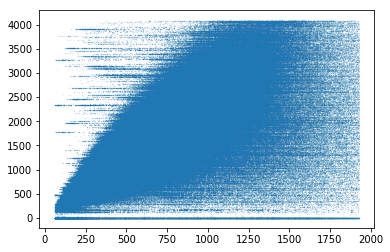

In [54]:
plt.plot('Duration Length', 'Distance', data=df, linestyle='none', marker='o', markersize=0.05)
plt.show()


## Casual Users vs. Members in Trip Length

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 15))
for i, col in enumerate(['Duration Length', 'Distance']):
    # Graph the distribution plots (seaborn doesn't allow default separation for distplot)
    for j, user in enumerate(df['User Type'].unique()):
        sns.distplot(df[df['User Type']==user][col], hist=False, ax=ax2[i])
    
    # Graph the boxplots
    sns.boxplot(x=col, y='User Type', data=df, ax=ax1[i])
    ax1[i].set_xlabel('')


## How Weather Affects Trip Length

In [138]:
mean_temp = new_df[['Duration Length', 'Distance', 'Mean Temp']]
mean_temp = mean_temp.dropna()



In [147]:
mean_temp['Mean Temp'] = mean_temp['Mean Temp'].astype(float)

In [154]:
mean_temp.loc[(mean_temp['Mean Temp'] >= -20) & (mean_temp['Mean Temp'] < -15), 'Temp Group'] = '-20~-15'
mean_temp.loc[(mean_temp['Mean Temp'] >= -15) & (mean_temp['Mean Temp'] < -10), 'Temp Group'] = '-15~-10'
mean_temp.loc[(mean_temp['Mean Temp'] >= -10) & (mean_temp['Mean Temp'] < -5), 'Temp Group'] = '-10~-5'
mean_temp.loc[(mean_temp['Mean Temp'] >= -5) & (mean_temp['Mean Temp'] < 0), 'Temp Group'] = '-5~0'
mean_temp.loc[(mean_temp['Mean Temp'] >= 0) & (mean_temp['Mean Temp'] < 5), 'Temp Group'] = '0~5'
mean_temp.loc[(mean_temp['Mean Temp'] >= 5) & (mean_temp['Mean Temp'] < 10), 'Temp Group'] = '5~10'
mean_temp.loc[(mean_temp['Mean Temp'] >= 10) & (mean_temp['Mean Temp'] < 15), 'Temp Group'] = '10~15'
mean_temp.loc[(mean_temp['Mean Temp'] >= 15) & (mean_temp['Mean Temp'] < 20), 'Temp Group'] = '15~20'
mean_temp.loc[(mean_temp['Mean Temp'] >= 20) & (mean_temp['Mean Temp'] < 25), 'Temp Group'] = '20~25'
mean_temp.loc[(mean_temp['Mean Temp'] >= 25) & (mean_temp['Mean Temp'] < 30), 'Temp Group'] = '25~30'
mean_temp.loc[(mean_temp['Mean Temp'] >= 30) & (mean_temp['Mean Temp'] < 35), 'Temp Group'] = '30~35'


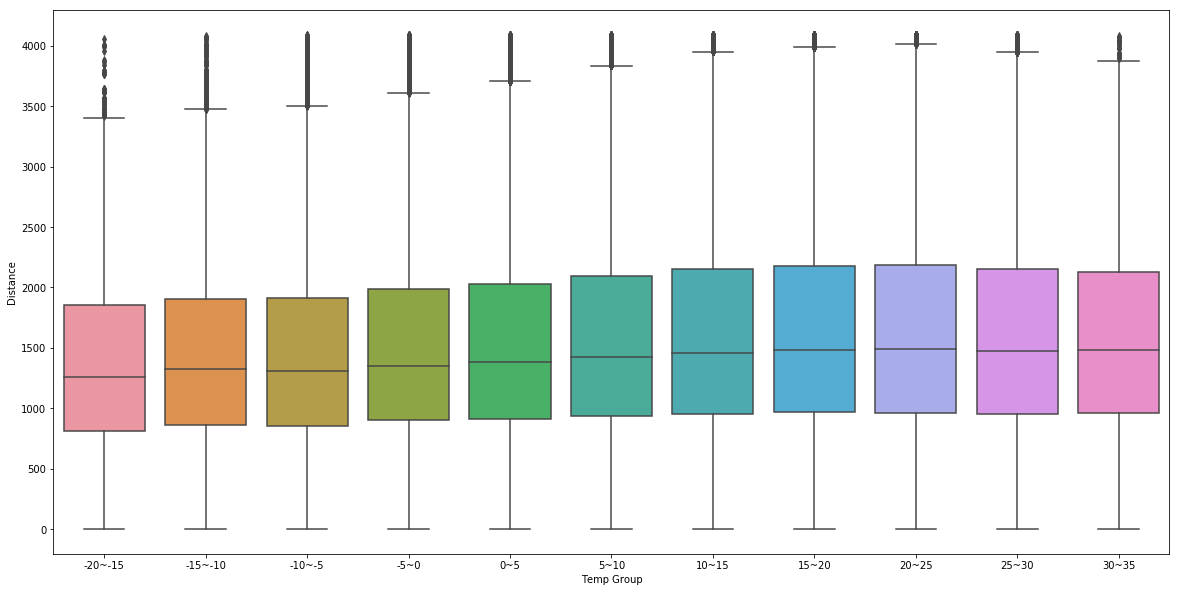

In [156]:
plt.figure(figsize=(20,10))
order = ['-20~-15', '-15~-10', '-10~-5', '-5~0', '0~5', '5~10', '10~15', '15~20', '20~25', '25~30', '30~35']
sns.boxplot(x = 'Temp Group' , y = 'Distance', data = mean_temp, order=order)

In [ ]:
total_rain = new_df[['Duration Length', 'Distance', 'Total Rain']]
total_rain = total_rain.dropna()
total_rain['Total Rain'] = total_rain['Total Rain'].astype(float)
total_rain.loc[(total_rain['Total Rain'] >= 0) & (total_rain['Total Rain'] < 5), 'Temp Group'] = '0-5'
